# Exploring Meaning Enhancement through Tokenized Language: A Spam Word Filtering experiment

Email spam is a major problem. Both personally, and globally too many emails received are unwanted and time wasting. It is a detriment to online discourse. 

Filtering spam emails out, intecepting them before the user ever has to spend attention and time on the email, has been studied and implemented for decades. One of the the earliest methods for filtering was to fit a supervised learning model to the words in a variety of emails which had been classified as spam or not. 

However, the intent of this project is not to study or improve spam filtering directly. That should probably be handled through much more sophisticated methods. What I want to understand is if tokenizing (link below) the language is a better vehicle for capturing the meaning and intent of the words. I want to compare some of the simpler models that we have studied and directly compare their performance when using the words as written in the emails, and the tokenized versions of those same words. 

Will simply tokenizing a bag of words enhance the ability of the model to predict spam? 

In [1]:
import os
import re
import csv

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize

from transformers import BertTokenizer

from IPython.display import IFrame

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn import svm

In [2]:
# Set the Wikipedia URL for the "Recall" section
wikipedia_url = 'https://en.wikipedia.org/wiki/Large_language_model#Probabilistic_tokenization'

# Display the Wikipedia section in a small window within the Jupyter Notebook cell
IFrame(wikipedia_url, width=1000, height=200)

# Data
Is the data source properly cited and
described? (including links, brief explanations)

The Data chosen for this project comes from kaggle (link below). It is a csv file format containing 5,172 emails broken up by the words counted in those emails. The column headers are the words found in the email and the body of the data are the integer counts of those words. If "lucky" appears three times in the email, then the number 3 will apear on the row for that email under the column called "lucky". There are 3,000 unique words (features) in this dataset and a label (Prediction) identifying the email as spam (1) or not (0). 

The size of the whole set is 5,172 (emails) x 3,002 (index + words + label) and all of the datatypes are integers except the first columns which is a string representing each email by a name followed by the number of the email in the list. 

(https://www.kaggle.com/datasets/balaka18/email-spam-classification-dataset-csv/data)

## Python Imports

# Data

In [3]:
# Read the data
data = pd.read_csv("emails.csv")

In [4]:
data.head()

,Email No.,the,to,ect,and,for,of,a,you,hou,...,connevey,jay,valued,lay,infrastructure,military,allowing,ff,dry,Prediction
0,Email 1,0,0,1,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Email 2,8,13,24,6,6,2,102,1,27,...,0,0,0,0,0,0,0,1,0,0
2,Email 3,0,0,1,0,0,0,8,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Email 4,0,5,22,0,5,1,51,2,10,...,0,0,0,0,0,0,0,0,0,0
4,Email 5,7,6,17,1,5,2,57,0,9,...,0,0,0,0,0,0,0,1,0,0


# Data Cleaning

Data Cleaning was specifically focused on turning the words into tokens, since that was the intent of the project. Cleaning  was minimal on this data set for the "base line" word analysis. 
The only cleaning required was to set the index of the frame to the email name/number and remove that column from the analysis. Leaving the email number in the analysis would greatly skew the analysis since the emails are grouped by the label. This would have resulted in the model fitting almost exclusivily to the email number provided or in other words, the order in the list is included in the email name/number and is 100% correlated with the classification, confounding the analysis.  
Two helper functions were defined to assist in tokenizing the data. 

In [5]:
# Set the first column as the index and remove it from the processing
data = data.set_index(data['Email No.'])

# Drop the Email No. column. Since the emails are organized as all spam first and then non spam for the rest, the
# Email number will directly correlate with the status of the email as spam or not and will crowd out the other features
data = data.drop('Email No.', axis=1)

In [6]:
# Create the tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", local_files_only=True)

In [7]:
# The email data is in a number format with each value representing the number of times the word appears in the email.
# In order to tokenize the email, it must be converted back into words which this helper function does
def word_count_to_text(row):
    words = []
    for word, count in row.items():
        # Multiply the count by the word and add it to words
        words.extend([word] * count)
    return " ".join(words)

# This function performs the tokenizing on the text and returns the tokens
def tokenize_text(text):
    tokens = tokenizer.tokenize(text)
    return " ".join(tokens)

In [8]:
# Define y as the classifier
y = data['Prediction']

# Define X as the word counts
X = data.iloc[:, :-1]

# Split the data into test and training
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [9]:
# Replace the words counts with the actual words to prepare for the next step
X_train_words = X_train_raw.apply(word_count_to_text, axis=1)
X_test_words = X_test_raw.apply(word_count_to_text, axis=1)

# Exploratory Data Analysis

Reviewing some random of the emails as bags of words provided some interesting perspectives. 

In [10]:
X_train_words[2]

'the the the ect for of a a a a a a a a hou in in on on on on on is i i i i i be be at at s s s s s com as or or me me meter meter re e e e e e e e e e e e e e e e e d d d d was an an t t t t t t t t t t t t t t t t j j j should out no l l l m m m m m m m m m m us day th th th th th month more about nom b b b b p p p production o o o o o o o o o o o o o o c c c he he he list nomination r r r r r r w than f f h h h h h h co u u u u u point product n n n n n n n n n n na september g g must st st pt y listed sept pro mm common ed met met oi prod mb min se mo mo mo da ti ti nat em et et ct ct ut mi po ea le'

In [11]:
X_train_words[20]

'the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to to ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect ect and and and and and and and and and and and and and and and and and and and and and and and and for for for for for for for for for for for of of of of of of of of of of of of of of of of of of a a a a a a a a a a a a a 

In [12]:
X_train_words[200]

'the the to to to to to to ect ect and and for for for for of of of of of of of a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a you you hou in in in in in in in in on on on on on on on on on is is is is is is is is is is this this this this i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i be be be have your your at at at we s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s are it it it it com as as or or or or or or not not not me me me me if please re re re re e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e our our d d d d d d d d d d d d d d d d d d d d d d d d an an an an an t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t up j j j should do do do do do am am get no no no l l l l l l l l l l l l l l l l so so so so m m m m m m m m m m m m m m m m m m m m information message message time one http th th th th th th 

In [13]:
X_train_words[3500]

'the the the the the the to to to to to ect ect ect ect ect ect ect ect and and and and for for for of of of a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a a you you hou in in in in in in in in in in in in on on on on on on on on on on on on is is is is is this i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i i be be be be that at at at at at at at we we s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s are by by as as as as as from gas gas gas or or or or or or or not not me me me re re re re re re e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e e can d d d d d d d d d d d d d d d d d d d d d d d d d d need an an an an an an an an an an forwarded t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t t up j j j j j j j j j j do am out no no no no no l l l l l l l l l l l l so m m m m m m m m m m m m m m m

Looking at the Data from a word count point of view, it is was difficult to detect any problems with this datset. However, browsing through the emails from a bag of words point of view immediately brought to light the sketchy nature of this dataset. The number of single letter and pieces of words in the emails indicates that there is something wrong with these emails, or at least, they are not anything like a typical email I have recieved, spam or not. The words are not in the original order, but it is difficult to see how the emails were ever written with so many of these single letters and two letter words. 

At minimum, since I am looking for tokenization of these words to see if it can help detect meaning, and the meaning inherent in even the non-spam emails is in doubt, this does not appear to be an acceptable data source. 

# Attempt 2
# Data

I found another source of spam emails on a website called spam assassin. This data is specifically intended to be used by spam filters and should represent a much higher quality dataset for my purposes. 

https://spamassassin.apache.org/old/publiccorpus/

The downloads consist of several packages of emails, obtained from a forum where good examples of spam and non-spam (referred to as "Ham" in this dataset) were requested. The emails are organized into separate downloads, including categories of "easy ham" and "hard ham" to indicate the assumed difficulty in distinguishing them. "Easy ham" refers to the obviously non-spam, narrative form emails, while "hard ham" includes news group and automated emails that may resemble spam at first glance but are actually desired information.

# Data Cleaning

The emails were more or less raw HTML and included the tehcnical handling informaiton for the email server. They were separated into header and body by looking for a simple empty line break. It was not a perfect separation, but it worked well enough for this purpose. There were less than 1% of the emails which contained some unreadable character or unique encoding, but those errors were ignored and characters removed. 

In [14]:
def parse_email(lines):
    header = []
    body = []
    is_body = False

    for line in lines:
        line = re.sub(r'[^a-zA-Z\s]', '', line).lower()  # Remove non-letter characters and capitalization
        line = line.strip()  # Remove newlines
        if is_body:
            body.append(line)
        elif line.strip() == "":
            is_body = True
        else:
            header.append(line)

    return " ".join(header), " ".join(body)

def read_and_write(email_folder, output_csv):
    with open(output_csv, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['Header', 'Body'])

        for email in os.listdir(email_folder):
            with open(os.path.join(email_folder, email), encoding='utf-8', errors='ignore') as f:
                raw_contents = f.readlines()
                header, body = parse_email(raw_contents)
                csv_writer.writerow([header, body])

spam_email_folder = "Spam"
spam_csv = "spam.csv"
read_and_write(spam_email_folder, spam_csv)

ham_email_folder = "Ham"
ham_csv = "ham.csv"
read_and_write(ham_email_folder, ham_csv)

## Conversion to word count format

This dataset required the opposite treatment from the last, where the emails are already in the text format, ready for transformation to tokens. 

In [15]:
def convert_to_word_counts(csv_file, predictor):
    data = pd.read_csv(csv_file)

    # Extract the body columns
    body_lines = data['Body']

    # Create an empty list to store word counts
    word_count_list = []

    for text in body_lines:
        words = text.split()
        # Create a dictionary to store word counts
        word_counts = {}
        # Iterate through the words
        for word in words:
            word_counts[word] = word_counts.get(word, 0) + 1

        # Add a column called "Prediction" with all 1's or 0's depending on if these are spam or ham
        word_counts['Prediction'] = predictor
        # Append the word_counts dictionary to the word_count_list
        word_count_list.append(word_counts)

    # Convert the word_count_list to a dataframe
    word_count_df = pd.DataFrame(word_count_list)

    return word_count_df

# Data processing is very intesnse to run the code below due to the large data size. 
# The file is avaialble in this notebook already. 

# # Convert Spam to word counts
# spam = convert_to_word_counts('spam.csv',1)
# ham = convert_to_word_counts('ham.csv',-1)

# combined_df = pd.concat([spam, ham], ignore_index=True, sort=False)
# # Fill NaN values with zeros and make sure the counts are integers
# combined_df = combined_df.fillna(0).astype(int)

# # Calculate the sum of each column
# column_sums = combined_df.sum()
# # Sort the columns by their total, excluding the 'Prediction' column
# sorted_columns = column_sums.drop('Prediction').sort_values(ascending=False).index
# # Keep only the top 5000 columns
# top_columns = sorted_columns[:5000]
# # Add back in the label column
# top_columns = top_columns.insert(len(top_columns), 'Prediction')
# # Reset the dataframe based on the top columns
# top_5000_words_df = combined_df[top_columns]

# top_5000_words_df.to_csv("emails_word_count.csv", index=False)

Running this script results in an email file with 9,348 emails and the top 5,000 words from those emails. 

In [16]:
# Read the data
data = pd.read_csv("emails_word_count.csv")

In [17]:
data.head()

,the,to,a,and,of,in,for,td,is,you,...,feedbackgeneral,catalog,bordertrtdp,invalid,bookabr,stylebackgroundposition,strings,workgroupabr,ar,Prediction
0,21,14,5,14,10,5,7,0,11,21,...,0,0,0,0,0,0,0,0,0,1
1,5,6,2,4,3,4,2,6,3,7,...,0,0,0,0,0,0,0,0,0,1
2,21,11,7,7,3,6,4,0,5,12,...,0,0,0,0,0,0,0,0,0,1
3,4,2,1,0,1,1,1,0,0,2,...,0,0,0,0,0,0,0,0,0,1
4,4,2,1,0,1,1,0,0,0,2,...,0,0,0,0,0,0,0,0,0,1


In [18]:
# Define y as the classifier
y = data['Prediction']

# Define X as the word counts
X = data.iloc[:, :-1]

# Split the data into test and training
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Return the word counts into text to make sure word order is held constant

In [19]:
# Replace the words counts with the actual words to prepare for the next step
X_train_words = X_train_raw.apply(word_count_to_text, axis=1)
X_test_words = X_test_raw.apply(word_count_to_text, axis=1)

# Exploratory Data Analysis

The same analysis performed above was repeated to review the emails. 

In [20]:
X_train_words[8]

'the the the to to of in for you you you i this if list list get free use like information please linux these group users link down below support irish might days offer wish maintainer unsubscription listmasterlinuxie legal thought risk guaranteed lose manager social leave events advice deserve fight child sociallinuxie cancer httpwwwlinuxiemailmanlistinfosocial'

In [21]:
X_train_words[80]

'contenttype contenttransferencoding charsetiso texthtml base'

In [22]:
X_train_words[800]

'the to a a for for for you you your your can more out just just free free free free use here even find day day link life off below top unsubscribe price working save save big insurance hours allow rate removal mortgage quote quote quote lower regular payment andor warranty older extend cars cars'

In [23]:
X_train_words[8000]

'the the the the the the the the the the the to to to to to to to to to a a a a and and and and and and and and and and of of of of in in in in in for for for for is is is is is you that that that that i i i i i i i this it it it it with with with with with on on from from from from from from from from from be by by by by are or as as have have not not not all but can can an list list list was my my my my more its no no out get received received received what there like id id id date dont message message other how than subject mailing mailing also he then sep sep sep sep sep sep into wrote most had software even need said much users those those very very messageid bulk sender re being two esmtp smtp smtp precedence too server xmailmanversion xbeenthere errorsto listid link mon mon mon read exmh exmh exmh code problem listunsubscribe network sure listsubscribe listpost listhelp listarchive cant x x x x x discussion days things things long replyto text fri fri inreplyto inreplyto differe

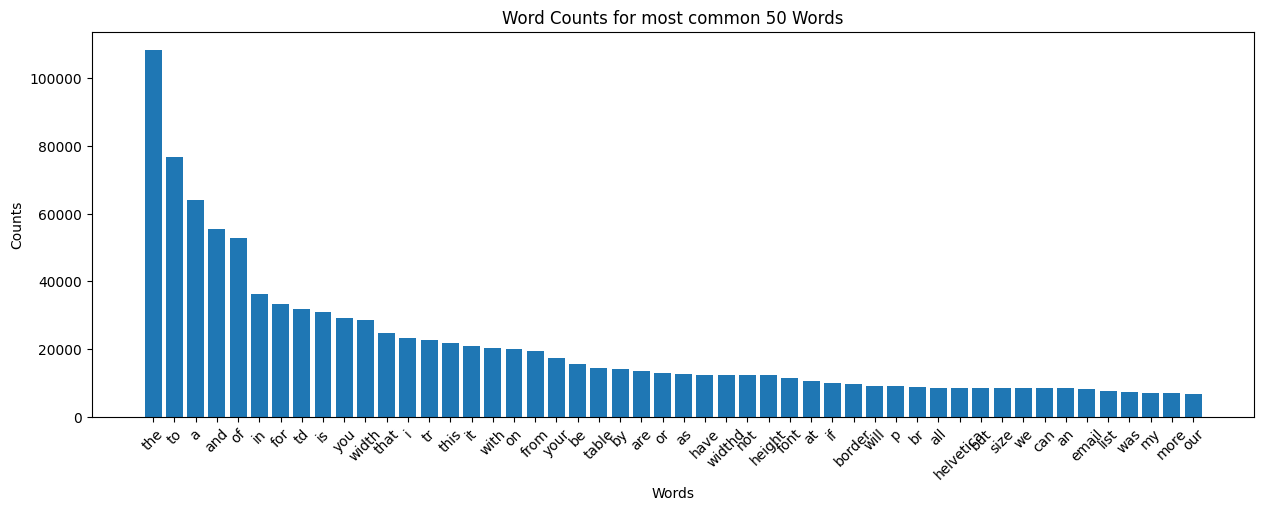

In [24]:
word_counts = data.sum(axis=0)
word_counts_50 = word_counts[:50]

plt.figure(figsize=(15, 5))
plt.bar(word_counts_50.index, word_counts_50.values)
plt.xlabel('Words')
plt.ylabel('Counts')
plt.title('Word Counts for most common 50 Words')
plt.xticks(rotation=45)
plt.show()

In [25]:

# Tokenize the text for the tokenized model
X_train_token = X_train_words.apply(tokenize_text)
X_test_token = X_test_words.apply(tokenize_text)

# Now that the text is in tokens, it needs to be put back into counts in order to be accessible to the models.
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train_token)
X_test_vect = vectorizer.transform(X_test_token)

# Models

3 different models were used for this evaluation. KNN, an AdaBoost ensemble decision tree, and a Support Vector Machine. 
All three models are applied to both the Raw text emails and the the tokenized data. This should provide an apples to apple comparison of whether or not tokenization of the English language can help with extracting the meaning from the text and thereby increase the ability to determine spam from the language used.

In [26]:
model_results = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], 
                             index=['KNN Words', 'KNN Tokens', 'AdaBoost Words', 'AdaBoost Tokens', 'SVM Words', 'SVM Tokens'])

In [27]:
# Model the data using KNN and evaluate the model
raw_model = KNeighborsClassifier(n_neighbors=5)
raw_model.fit(X_train_raw, y_train)
y_pred = raw_model.predict(X_test_raw)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['KNN Words'] = [accuracy, precision, recall, f1]

In [28]:
# Rebuild the model using the tokenized counts
token_model = KNeighborsClassifier(n_neighbors=5)
token_model.fit(X_train_vect, y_train)
y_pred = token_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['KNN Tokens'] = [accuracy, precision, recall, f1]

In [29]:
# Also try with AdaBoost
raw_model = AdaBoostClassifier(n_estimators=100)
raw_model.fit(X_train_raw, y_train)
y_pred = raw_model.predict(X_test_raw)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['AdaBoost Words'] = [accuracy, precision, recall, f1]

In [30]:
# Rebuild the model using the tokenized counts
token_model = AdaBoostClassifier(n_estimators=100)
token_model.fit(X_train_vect, y_train)
y_pred = token_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['AdaBoost Tokens'] = [accuracy, precision, recall, f1]

# Tuning
For the SVC model, c and gamma were tuned based on the smaller test subset

## Warning, the next cell will result in extremely long runtimes to process all of the data. 

Skipping these cells will not cause any problems later on in the notebook. 

In [34]:
C_range = np.logspace(-5, 5, num=5, base=2)
gamma_range = np.logspace(-5, 5, num=5, base=2)

param_grid = {
    'C': C_range,
    'gamma': gamma_range,
}

grid = GridSearchCV(estimator=svm.SVC(), param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid.fit(X_test_raw,y_test)
print() 

Fitting 3 folds for each of 25 candidates, totalling 75 fits



In [31]:
# From Week 6 homework
class MidpointNormalize(Normalize):

    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    
def plotSearchGrid(grid):
    
    scores = [x for x in grid.cv_results_["mean_test_score"]]
    scores = np.array(scores).reshape(len(grid.param_grid["C"]), len(grid.param_grid["gamma"]))

    plt.figure(figsize=(10, 8))
    plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
    plt.imshow(scores, interpolation='nearest', cmap=plt.cm.hot,
               norm=MidpointNormalize(vmin=0.2, midpoint=0.92))
    plt.xlabel('gamma')
    plt.ylabel('C')
    plt.colorbar()
    plt.xticks(np.arange(len(grid.param_grid["gamma"])), grid.param_grid["gamma"], rotation=45)
    plt.yticks(np.arange(len(grid.param_grid["C"])), grid.param_grid["C"])
    plt.title('Validation accuracy')
    plt.show()

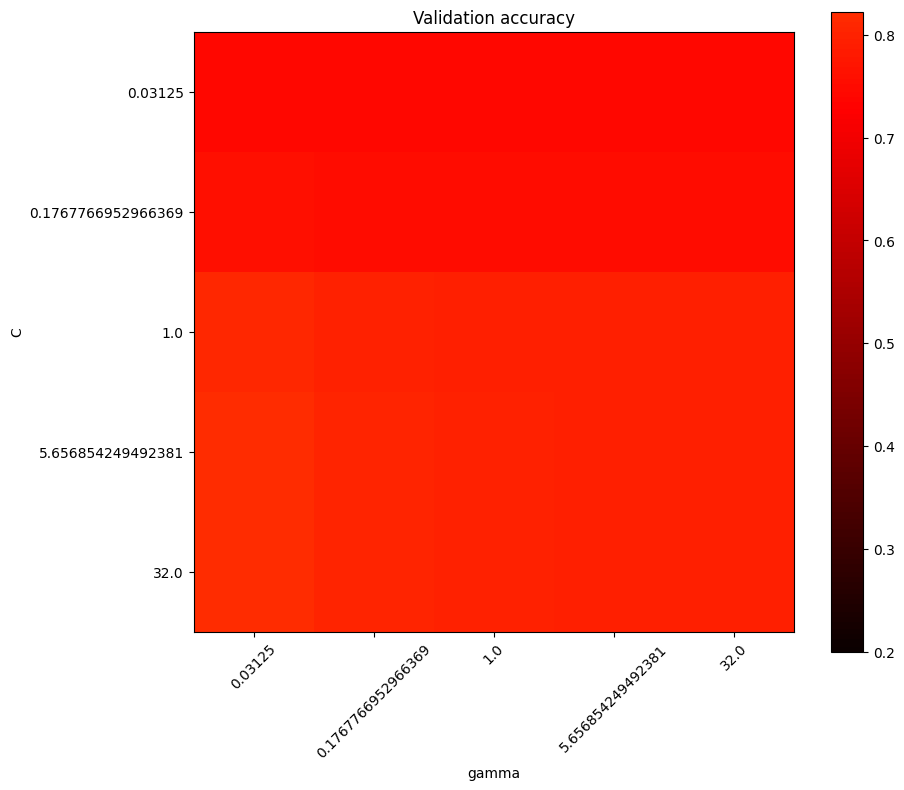

In [35]:
plotSearchGrid(grid)

However, this did not result in distinguishable differences between the different models, so was not useful in choosing C or gamma. As a result, the default values were used. 

In [37]:
# Also try with SVM
raw_model = svm.SVC()
raw_model.fit(X_train_raw, y_train)
y_pred = raw_model.predict(X_test_raw)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['SVM Words'] = [accuracy, precision, recall, f1]

In [38]:
# Rebuild the model using the tokenized counts
token_model = svm.SVC()
token_model.fit(X_train_vect, y_train)
y_pred = token_model.predict(X_test_vect)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

model_results.loc['SVM Tokens'] = [accuracy, precision, recall, f1]

# Results

The tokenization of the email text results were quite mixed. With KNN, the tokenization of the text resulted in greater accuracy of the predictions. For the other two models, the tokenization of the language did not result in an increase in the ability to predict Spam from the text of the email. In particular, the SVM model suffered a major loss in recall by breaking the emails into tokens. 



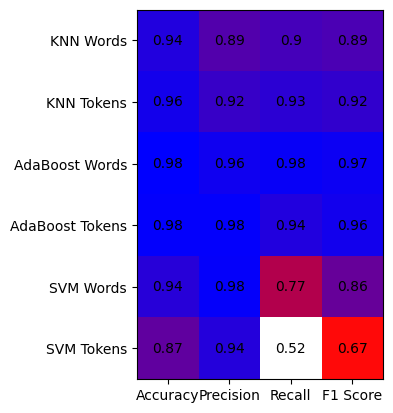

In [44]:
# Force the model results datatype to numbers since they started as an object
model_results = model_results.apply(pd.to_numeric, errors='coerce')

# Colormap
colors = ["white", "red", "purple", 'blue']
cmap = mcolors.LinearSegmentedColormap.from_list("", colors)

# Heatmap
fig, ax = plt.subplots()
ax.imshow(model_results, cmap=cmap)

# Cell values as text
for i in range(model_results.shape[0]):
    for j in range(model_results.shape[1]):
        ax.text(j, i, round(model_results.iloc[i, j], 2), ha="center", va="center", color="black")

# labels
ax.set_xticks(np.arange(model_results.shape[1]))
ax.set_yticks(np.arange(model_results.shape[0]))
ax.set_xticklabels(model_results.columns)
ax.set_yticklabels(model_results.index)

# Show the plot
plt.show()

# Conclusion

Attempting to tokenize the specific word count of emails while keeping all other factors constant did not result in a significant or clear increase in accuracy by any consistent measure. Surprisingly, I also found it odd that tokenizing the language led to worse spam detection in most cases. My initial assumption was that tokenizing the language would group together similar words and increase the value of a word-by-word classification. However, this appears not to be the case.

One theory I have to explain this is that the tokenization process might be adding information to misspelled or fragmented words. One of the goals of tokenizing is to impute meaning from poorly communicated information, and maybe the spam emails are benefitting from the "good will" attempts to correct language by the language model that would otherwise be picked up by a traditional bag of words approach.

It was crucial to see that the first dataset was not representative of language. An inherent problem in more sophisticated statistical analysis is that converting the information into higher-order systems, such as word counts or even vectors of tokens, makes these systems more challenging to monitor as a researcher. If the data were mangled by a poorly written python script and simultaneously converted to tokens, it would be somewhat difficult to detect since the tokenization is not human-readable. Perhaps an AI monitoring the process can help, or there may be techniques of which I am not aware, but at the very least, this is a problem in need of a solution.